# Denver 2016 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402965, 14)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Hour       402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Month      402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


### Re-arrange columns to set up target class

In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [10]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [16]:
dFW['Number_Of_Checkouts'].sum()

402965

In [17]:
dFW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6881 entries, 0 to 6880
Data columns (total 5 columns):
Checkout_Date          6881 non-null object
Checkout_Month         6881 non-null int64
Checkout_WeekDay       6881 non-null int64
Checkout_Hour          6881 non-null int64
Number_Of_Checkouts    6881 non-null int64
dtypes: int64(4), object(1)
memory usage: 268.9+ KB


In [18]:
dFW.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Number_Of_Checkouts
0,2016-01-01,1,4,8,3
1,2016-01-01,1,4,9,8
2,2016-01-01,1,4,10,7
3,2016-01-01,1,4,11,22
4,2016-01-01,1,4,12,13


In [19]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
Date                   8784 non-null object
Checkout_Hour          8784 non-null int64
apparentTemperature    8784 non-null float64
cloudCover             8782 non-null float64
humidity               8784 non-null float64
temperature            8784 non-null float64
visibility             8784 non-null float64
windSpeed              8784 non-null float64
Checkout_WeekDay       8784 non-null int32
Checkout_Month         8784 non-null int32
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 617.7+ KB


In [20]:
dW.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay,Checkout_Month
0,2016-01-01,0,-0.35,0.04,0.80,8.12,9.01,4.56,4,1
1,2016-01-01,1,6.77,0.04,0.80,6.77,9.33,2.11,4,1
2,2016-01-01,2,6.23,0.00,0.80,6.23,9.48,2.36,4,1
3,2016-01-01,3,-2.89,0.00,0.79,6.88,9.63,5.35,4,1
4,2016-01-01,4,-2.05,0.00,0.80,6.19,9.53,4.19,4,1


In [21]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [22]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 14 columns):
Date                   8784 non-null object
Checkout_Hour          8784 non-null int64
apparentTemperature    8784 non-null float64
cloudCover             8782 non-null float64
humidity               8784 non-null float64
temperature            8784 non-null float64
visibility             8784 non-null float64
windSpeed              8784 non-null float64
Checkout_WeekDay_x     8784 non-null int32
Checkout_Month_x       8784 non-null int32
Checkout_Date          6880 non-null object
Checkout_Month_y       6880 non-null float64
Checkout_WeekDay_y     6880 non-null float64
Number_Of_Checkouts    6880 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 960.8+ KB


In [23]:
dT.tail()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8779,2016-12-31,19,26.12,0.03,0.53,31.41,10.0,5.29,5,12,2016-12-31,12.0,5.0,1.0
8780,2016-12-31,20,24.59,0.17,0.54,30.52,10.0,5.85,5,12,2016-12-31,12.0,5.0,11.0
8781,2016-12-31,21,23.44,0.14,0.57,29.21,10.0,5.39,5,12,2016-12-31,12.0,5.0,6.0
8782,2016-12-31,22,24.29,0.01,0.57,28.95,10.0,4.23,5,12,2016-12-31,12.0,5.0,9.0
8783,2016-12-31,23,23.89,0.13,0.59,28.18,10.0,3.82,5,12,2016-12-31,12.0,5.0,7.0


In [24]:
dT['Number_Of_Checkouts'].sum()

402962.0

In [25]:
dT.isnull().values.any()

True

In [26]:
nan_rows = dT[dT.isnull().T.any().T]

In [27]:
dT = dT.drop(dT.index[nan_rows.index])

In [28]:
dT.isnull().values.any()

False

In [29]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6880 entries, 8 to 8783
Data columns (total 14 columns):
Date                   6880 non-null object
Checkout_Hour          6880 non-null int64
apparentTemperature    6880 non-null float64
cloudCover             6880 non-null float64
humidity               6880 non-null float64
temperature            6880 non-null float64
visibility             6880 non-null float64
windSpeed              6880 non-null float64
Checkout_WeekDay_x     6880 non-null int32
Checkout_Month_x       6880 non-null int32
Checkout_Date          6880 non-null object
Checkout_Month_y       6880 non-null float64
Checkout_WeekDay_y     6880 non-null float64
Number_Of_Checkouts    6880 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 752.5+ KB


In [30]:
dT.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8,2016-01-01,8,-5.68,0.00,0.73,6.63,10.00,7.61,4,1,2016-01-01,1.0,4.0,3.0
9,2016-01-01,9,4.28,0.08,0.64,13.85,10.00,6.33,4,1,2016-01-01,1.0,4.0,8.0
10,2016-01-01,10,9.49,0.16,0.54,19.73,10.00,8.55,4,1,2016-01-01,1.0,4.0,7.0
11,2016-01-01,11,19.04,0.16,0.42,25.91,10.00,5.93,4,1,2016-01-01,1.0,4.0,22.0
12,2016-01-01,12,23.17,0.16,0.37,29.53,9.97,6.15,4,1,2016-01-01,1.0,4.0,13.0


In [31]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [32]:
dML = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [33]:
dML.shape

(6849, 11)

In [34]:
data = dML.copy(deep=True)

In [35]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [36]:
data = data[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [37]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts
8,2016-01-01,1,4,8,6.63,-5.68,0.00,0.73,7.61,10.00,3.0
9,2016-01-01,1,4,9,13.85,4.28,0.08,0.64,6.33,10.00,8.0
10,2016-01-01,1,4,10,19.73,9.49,0.16,0.54,8.55,10.00,7.0
11,2016-01-01,1,4,11,25.91,19.04,0.16,0.42,5.93,10.00,22.0
12,2016-01-01,1,4,12,29.53,23.17,0.16,0.37,6.15,9.97,13.0


In [38]:
month_dummies = pd.get_dummies(data.Checkout_Month, prefix='month')

In [39]:
weekday_dummies = pd.get_dummies(data.Checkout_WeekDay, prefix='weekday')

In [40]:
hour_dummies = pd.get_dummies(data.Checkout_Hour, prefix='hour')

In [41]:
data = pd.concat([data, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [42]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
8,2016-01-01,1,4,8,6.63,-5.68,0.00,0.73,7.61,10.00,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2016-01-01,1,4,9,13.85,4.28,0.08,0.64,6.33,10.00,8.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2016-01-01,1,4,10,19.73,9.49,0.16,0.54,8.55,10.00,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11,2016-01-01,1,4,11,25.91,19.04,0.16,0.42,5.93,10.00,22.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12,2016-01-01,1,4,12,29.53,23.17,0.16,0.37,6.15,9.97,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
dUT = data.sample(n=10, random_state=123)

In [44]:
del_rows = dUT.index

In [45]:
data.drop(del_rows, axis=0, inplace=True)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 49 columns):
Checkout_Date           6839 non-null object
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
Temperature             6839 non-null float64
Apparent_Temperature    6839 non-null float64
Cloud_Cover             6839 non-null float64
Humidity                6839 non-null float64
Wind_Speed              6839 non-null float64
Visibility              6839 non-null float64
Number_Of_Checkouts     6839 non-null float64
month_1                 6839 non-null uint8
month_2                 6839 non-null uint8
month_3                 6839 non-null uint8
month_4                 6839 non-null uint8
month_5                 6839 non-null uint8
month_6                 6839 non-null uint8
month_7                 6839 non-null uint8
month_8                 6839 non-null uint8
month_9                 6839 non-null uint

In [47]:
data = data[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [48]:
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,8,6.63,-5.68,0.00,7.61,0.73,10.00,3.0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,9,13.85,4.28,0.08,6.33,0.64,10.00,8.0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,10,19.73,9.49,0.16,8.55,0.54,10.00,7.0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,11,25.91,19.04,0.16,5.93,0.42,10.00,22.0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,4,12,29.53,23.17,0.16,6.15,0.37,9.97,13.0


In [49]:
array = data.values

In [50]:
X = array[:,0:47]
X[0]

array([  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   4.  ,
         8.  ,   6.63,  -5.68,   0.  ,   7.61,   0.73,  10.  ])

In [51]:
y = array[:,47]
y[0]

3.0

## Feature Correlations

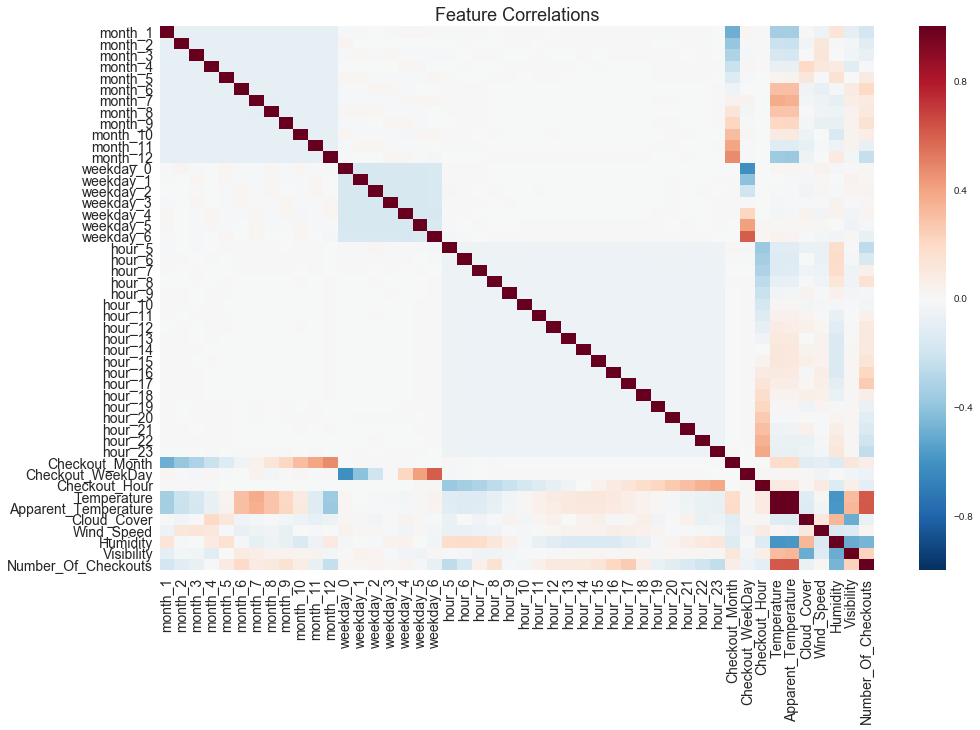

In [52]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [53]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Modeling - All Features

### Plot Feature Importance

In [54]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Get Regression Metrics

In [55]:
#def get_regression_metrics(model, actual, predicted):
#    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)}
#    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
#    dML_metrics.columns = [model]
#    return dML_metrics

In [56]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)**0.5,
                          'RMSE' : metrics.mean_squared_error(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

### Linear Regression

In [57]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.intercept_: {}".format(lr.intercept_))
print("lr.coef_: {}".format(lr.coef_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.intercept_: 254016185944.39978
lr.coef_: [  9.65128666e+06   9.65128752e+06   9.65128978e+06   9.65129476e+06
   9.65129865e+06   9.65129489e+06   9.65127290e+06   9.65128126e+06
   9.65129164e+06   9.65129102e+06   9.65128420e+06   9.65127924e+06
  -2.80197550e+11  -2.80197550e+11  -2.80197550e+11  -2.80197550e+11
  -2.80197550e+11  -2.80197550e+11  -2.80197550e+11   2.61717129e+10
   2.61717129e+10   2.61717130e+10   2.61717130e+10   2.61717129e+10
   2.61717129e+10   2.61717130e+10   2.61717130e+10   2.61717130e+10
   2.61717130e+10   2.61717130e+10   2.61717130e+10   2.61717130e+10
   2.61717130e+10   2.61717129e+10   2.61717129e+10   2.61717129e+10
   2.61717129e+10   2.61717129e+10   2.65306890e-01   8.38637352e-01
  -6.30876330e+00  -2.01878784e-01  -8.17053933e+00   1.72807478e+00]

Training Set Score: 0.682
Testing Set Score: 0.692


,Linear Regression
R Squared,0.831734
RMSE,639.092634


### Lasso Regression

In [58]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("lso.intercept_: {}".format(lso.intercept_))
print("lso.coef_: {}".format(lso.coef_))
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

lso.intercept_: -1.7575958771748361
lso.coef_: [ -1.53796409  -0.77714045   1.09117154   5.76199867   9.47309706
   5.35376778 -16.48806425  -7.99555899   2.31655049   1.98951078
  -4.24049617  -8.87653716  -2.14191667   0.           1.0846059    0.
   2.88652843  -5.92165846 -12.24256318 -42.22196309 -21.25679178
  17.22763722  30.67019832  -3.34949871 -10.77195523  -0.           3.53986371
   3.57783364   4.11004696   8.89185803  25.11399182  36.05662545
   3.54864328 -18.1169004  -25.06795063 -27.20121497 -34.41068894
 -44.19152407   0.30051994   0.83384882  -5.48538494  -0.19991887
  -7.29677101   1.76634333]
Training Set Score: 0.682
Testing Set Score: 0.692


,Lasso Regression
R Squared,0.831658
RMSE,639.355954


### Ridge Regression

In [59]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.01)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("rge.intercept_: {}".format(rge.intercept_))
print("rge.coef_: {}".format(rge.coef_))
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

rge.intercept_: -1.7575958771748361
rge.coef_: [ -1.53796409  -0.77714045   1.09117154   5.76199867   9.47309706
   5.35376778 -16.48806425  -7.99555899   2.31655049   1.98951078
  -4.24049617  -8.87653716  -2.14191667   0.           1.0846059    0.
   2.88652843  -5.92165846 -12.24256318 -42.22196309 -21.25679178
  17.22763722  30.67019832  -3.34949871 -10.77195523  -0.           3.53986371
   3.57783364   4.11004696   8.89185803  25.11399182  36.05662545
   3.54864328 -18.1169004  -25.06795063 -27.20121497 -34.41068894
 -44.19152407   0.30051994   0.83384882  -5.48538494  -0.19991887
  -7.29677101   1.76634333]
Training Set Score: 0.682
Testing Set Score: 0.692


,Ridge Regression
R Squared,0.831658
RMSE,639.355954


### Bayesian Ridge Regression

In [60]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("brr.intercept_: {:.3f}".format(brr.intercept_))
print("brr.coef_: {}".format(brr.coef_))
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

brr.intercept_: -8.313
brr.coef_: [ -8.07413225e-01  -6.47305688e-03   2.17407900e+00   6.99210561e+00
   1.08339021e+01   6.92977553e+00  -1.49818668e+01  -6.61553441e+00
   3.76404069e+00   3.23883274e+00  -3.37348092e+00  -8.14796725e+00
   1.34293489e-01   2.36958267e+00   3.45488281e+00   2.34396416e+00
   5.27005027e+00  -3.63035706e+00  -9.94241634e+00  -3.71690110e+01
  -1.64165734e+01   2.20825829e+01   3.54259518e+01   1.38936696e+00
  -5.97791587e+00   4.91418202e+00   8.63302014e+00   8.65083706e+00
   9.19896821e+00   1.39570383e+01   2.99978015e+01   4.08407896e+01
   8.62480723e+00  -1.32507992e+01  -2.01344770e+01  -2.22398238e+01
  -2.94193037e+01  -3.91074418e+01   2.76930025e-01   8.38821352e-01
  -5.87768365e+00  -1.99585751e-01  -8.16287713e+00   1.72254613e+00]
Training Set Score: 0.682
Testing Set Score: 0.692


,Bayesion Ridge Regression
R Squared,0.831606
RMSE,639.536119


### Decision Tree Regression

In [61]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.731


,Decision Tree Regression
R Squared,0.854938
RMSE,557.941520


### Random Forest Regression

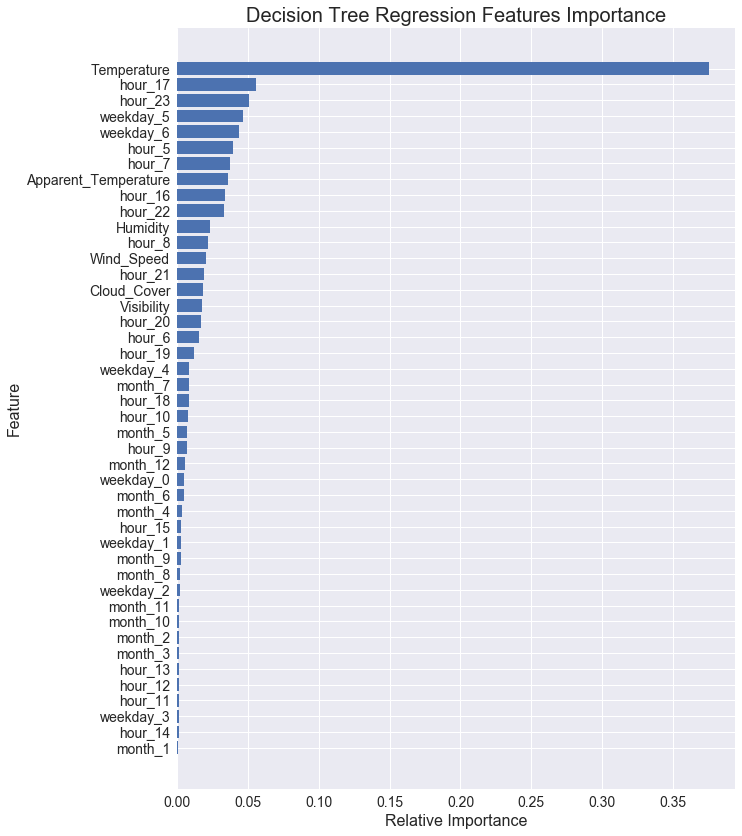

In [62]:
plot_feature_importances(dtr, 'Decision Tree Regression')

In [63]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.969
Testing Set Score: 0.844


,Random Forest Regression
R Squared,0.918727
RMSE,323.343070


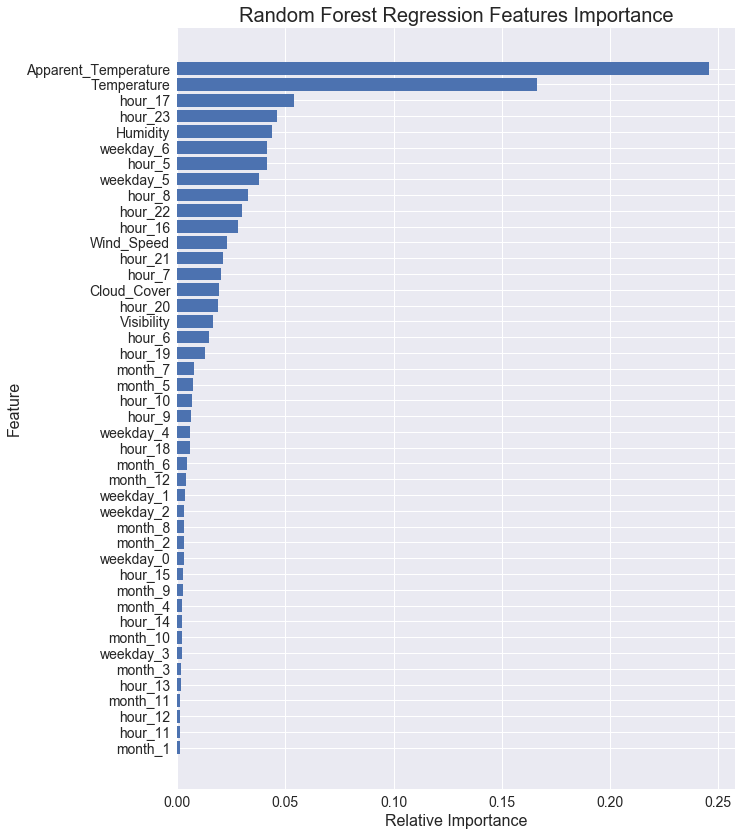

In [64]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [65]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.852


,Extra Trees Regression
R Squared,0.922904
RMSE,307.394703


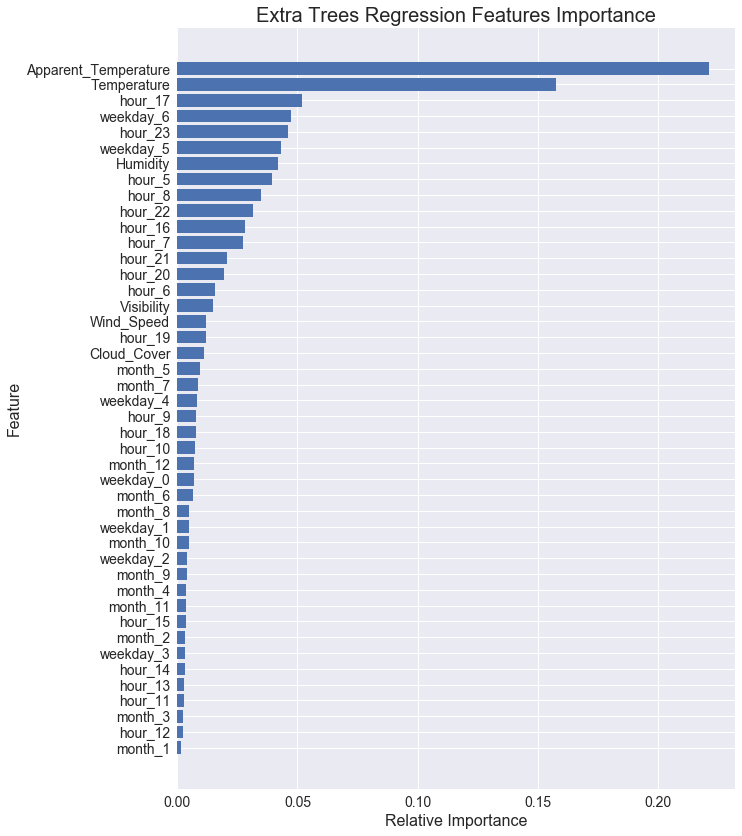

In [66]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [67]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.584
Testing Set Score: 0.486


,Nearest Neighbors Regression
R Squared,0.696933
RMSE,1066.371121


## Regression Summary - Categorical Feature Set

In [68]:
# Regression Summary
print("Regression Summary - Categorical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics,
                                dtr_metrics, rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary - Categorical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.831734,0.831658,0.831658,0.831606,0.854938,0.918727,0.922904,0.696933
RMSE,639.092634,639.355954,639.355954,639.536119,557.941520,323.343070,307.394703,1066.371121


## 3. Modeling - Selected Features

In [69]:
data = dML.copy(deep=True)

In [70]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

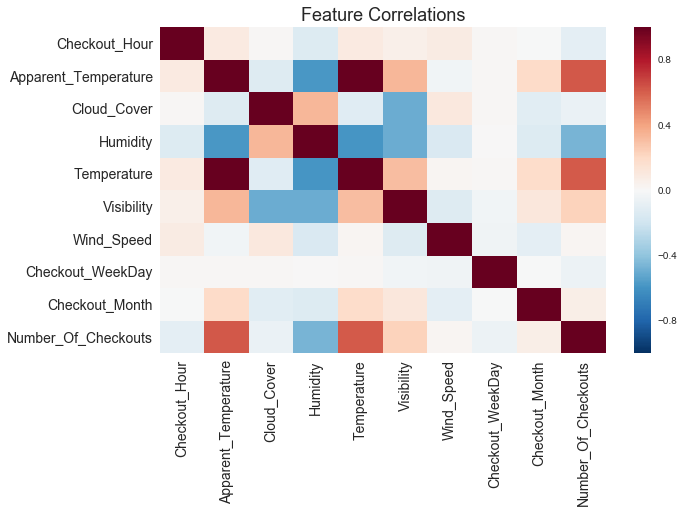

In [71]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
            'Number_Of_Checkouts']
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [72]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]

In [73]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [74]:
array = data.values
X = array[:,0:9]
X[0]

array([  1.  ,   4.  ,   8.  ,   6.63,  -5.68,   0.  ,   7.61,   0.73,  10.  ])

In [75]:
y = array[:,9]
y[0]

3.0

In [76]:
features = ["Checkout_Month", "Checkout_WeekDay", 'Checkout_Hour', 'Temperature', 
            'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Number_Of_Checkouts"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [77]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Linear Regression

In [78]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [ -0.88168351  -1.3913632   -1.37706092  -0.60088188   1.7275582
  18.18026322   0.14125982 -42.75967571  -0.39344674]
lr.intercept_: 53.016380615962824

Training Set Score: 0.433
Testing Set Score: 0.448


,Linear Regression
R Squared,0.669090
RMSE,1142.475389


### Lasso Regression

In [79]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.1)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.433
Testing Set Score: 0.447


,Lasso Regression
R Squared,0.668243
RMSE,1144.817931


### Ridge Regression

In [80]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.1)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.433
Testing Set Score: 0.447


,Ridge Regression
R Squared,0.668243
RMSE,1144.817931


### Bayesian Ridge Regression

In [81]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.433
Testing Set Score: 0.447


,Bayesion Ridge Regression
R Squared,0.668785
RMSE,1143.318754


### Decision Tree Regression

In [82]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.741


,Decision Tree Regression
R Squared,0.861079
RMSE,534.799635


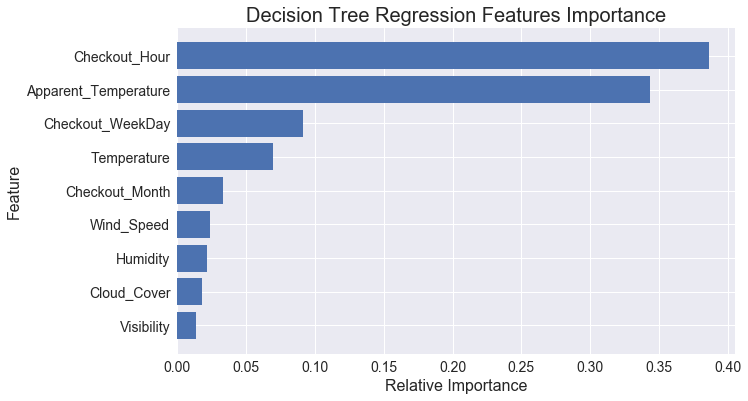

In [83]:
plot_feature_importances(dtr, 'Decision Tree Regression')


### Random Forest Regression

In [84]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.975
Testing Set Score: 0.854


,Random Forest Regression
R Squared,0.924077
RMSE,302.171818


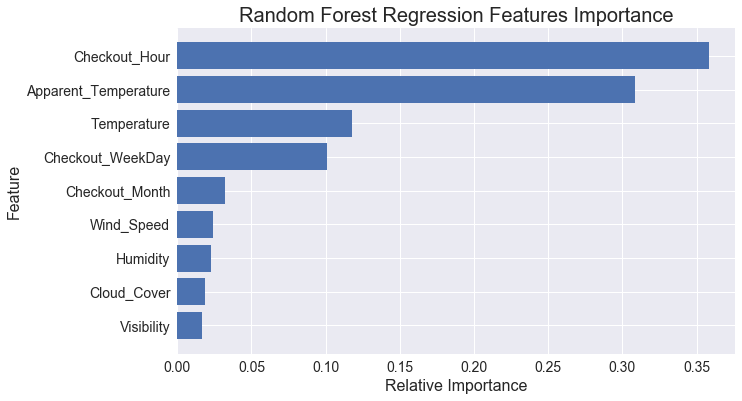

In [85]:
plot_feature_importances(rfr, 'Random Forest Regression')

### Extra Trees Regression

In [86]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.838


,Extra Trees Regression
R Squared,0.915609
RMSE,334.397000


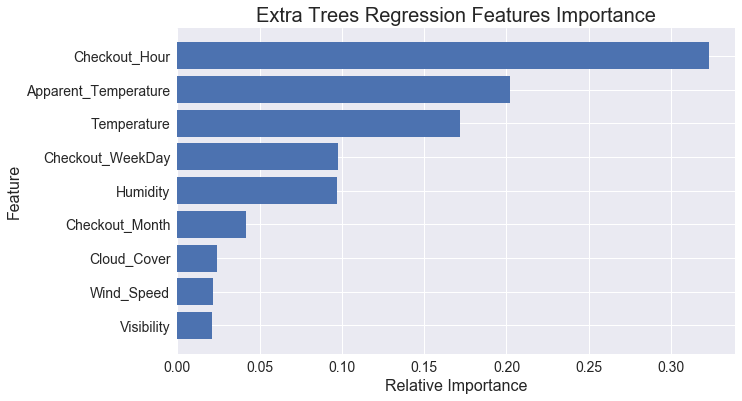

In [87]:
plot_feature_importances(etr, 'Extra Trees Regression')

### Nearest Neighbors Regression

In [88]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.880
Testing Set Score: 0.646


,Nearest Neighbors Regression
R Squared,0.803447
RMSE,733.229106


## Regression Summary with Numerical Feature Set

In [89]:
# Regression Summary
print("Regression Summary With Numericical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics, dtr_metrics,
                                rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary With Numericical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.669090,0.668243,0.668243,0.668785,0.861079,0.924077,0.915609,0.803447
RMSE,1142.475389,1144.817931,1144.817931,1143.318754,534.799635,302.171818,334.397000,733.229106


## Test Random Forest Regressor on Untouched Samples

In [90]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
pred_X = dUT[features]
pred_y = dUT['Number_Of_Checkouts']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
pred_y_array = pred_array[:,9]
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X, y)
pred = rfr.predict(pred_X_array)
print('pred =', pred)
print('act = ', pred_y_array)

pred = [  95.9   13.    56.3  112.    71.9   36.8   14.2   98.9   64.4   13.9]
act =  [  92.   12.   55.  111.   76.   41.    8.   81.   65.   14.]


## 4. Summary

With reduced features, the Random Forest model attains the highest accuracy with the lowest RMSE. The linear models have almost four times higher RMSE values as compared to the Random Forest model. This suggests that the prediction can be improved even with reduced features.